# Mortality Mysteries Notebook

In [15]:
# Increase the output limit for the current notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, invgamma
import pymc as pm
import arviz as az

In [17]:
# mortality data
data = {
    'Accidents': [33058, 34452, 31315, 24516, 24614],
    'Homicide': [6712, 7571, 7125, 5341, 5234],
    'Suicide': [8663, 8862, 8454, 8059, 8020],
    'Heart Disease': [3789, 4155, 3984, 3495, 3561],
    'Malignant Neoplasms': [3641, 3615, 3573, 3577, 3684]
}

In [18]:
prior_data = {
    'Accidents': [11890, 11769, 11839, 12569, 12541, 13032, 13997, 14954, 14977, 14588, 14062, 14573, 15518, 15851, 16209, 17335, 19795, 23984, 25669],
    'Homicide': [4231, 4164, 5204, 4489, 4516, 4495, 4752, 4725, 4758, 4610, 4222, 4258, 4185, 4342, 4236, 4173, 4863, 5376, 5488],
    'Suicide': [5142, 4830, 5123, 5077, 5118, 5109, 5032, 5038, 5327, 5344, 5364, 5785, 6133, 6271, 6392, 6639, 6994, 7405, 7987],
    'Heart Disease': [3066, 2958, 3160, 3165, 3250, 3163, 3249, 3307, 3223, 3254, 3174, 3222, 3301, 3231, 3258, 3341, 3522, 3445, 3681],
    'Malignant Neoplasms': [4005, 3916, 3994, 3872, 3741, 3633, 3601, 3656, 3463, 3521, 3659, 3619, 3499, 3674, 3673, 3624, 3704, 3791, 3616]
}

In [56]:
cause_labels = {
    0: 'Accidents',
    1: 'Homicide',
    2: 'Suicide',
    3: 'Heart Disease',
    4: 'Malignant Neoplasms',
    5: 'Hypothetical 6th'
}

### Set priors

We use informative priors from prior year's historical data.

In [27]:
prior_means = {cause: np.mean(prior_data[cause]) for cause in data.keys()}
prior_stds = {cause: np.std(prior_data[cause]) for cause in data.keys()}


# Flatten the data
all_data = [item for sublist in prior_data.values() for item in sublist]

# Calculate variance
common_variance = np.var(all_data)

print(f"The variance of the entire dataset is: {common_variance:.2f}")

#use common variance
common_sigma = np.sqrt(common_variance)

print(f"The standard deviation of the entire dataset is: {common_sigma:.2f}")

The variance of the entire dataset is: 23845098.23
The standard deviation of the entire dataset is: 4883.14


### Set global vars

In [20]:
# Set consistent sampling parameters
n_samples = 10000
n_tune = 2000

y = np.array(list(data.values()))
K, N = y.shape  # K: number of causes, N: number of years

In [36]:
y2 = np.array(list(prior_data.values()))
mu = y2.mean(axis=1)
tau = 1 / y2.var(axis=1)
print("mu = ", mu)
print("tau = ", tau)

tau = np.full(y2.shape[0], 1 / common_variance)
print("tau = ", tau)

mu =  [15534.31578947  4583.52631579  5795.26315789  3261.57894737
  3697.94736842]
tau =  [7.08460047e-08 6.22244371e-06 1.24497916e-06 4.13854425e-05
 4.38885285e-05]
tau =  [4.19373403e-08 4.19373403e-08 4.19373403e-08 4.19373403e-08
 4.19373403e-08]


# Separate Models

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 5 seconds.


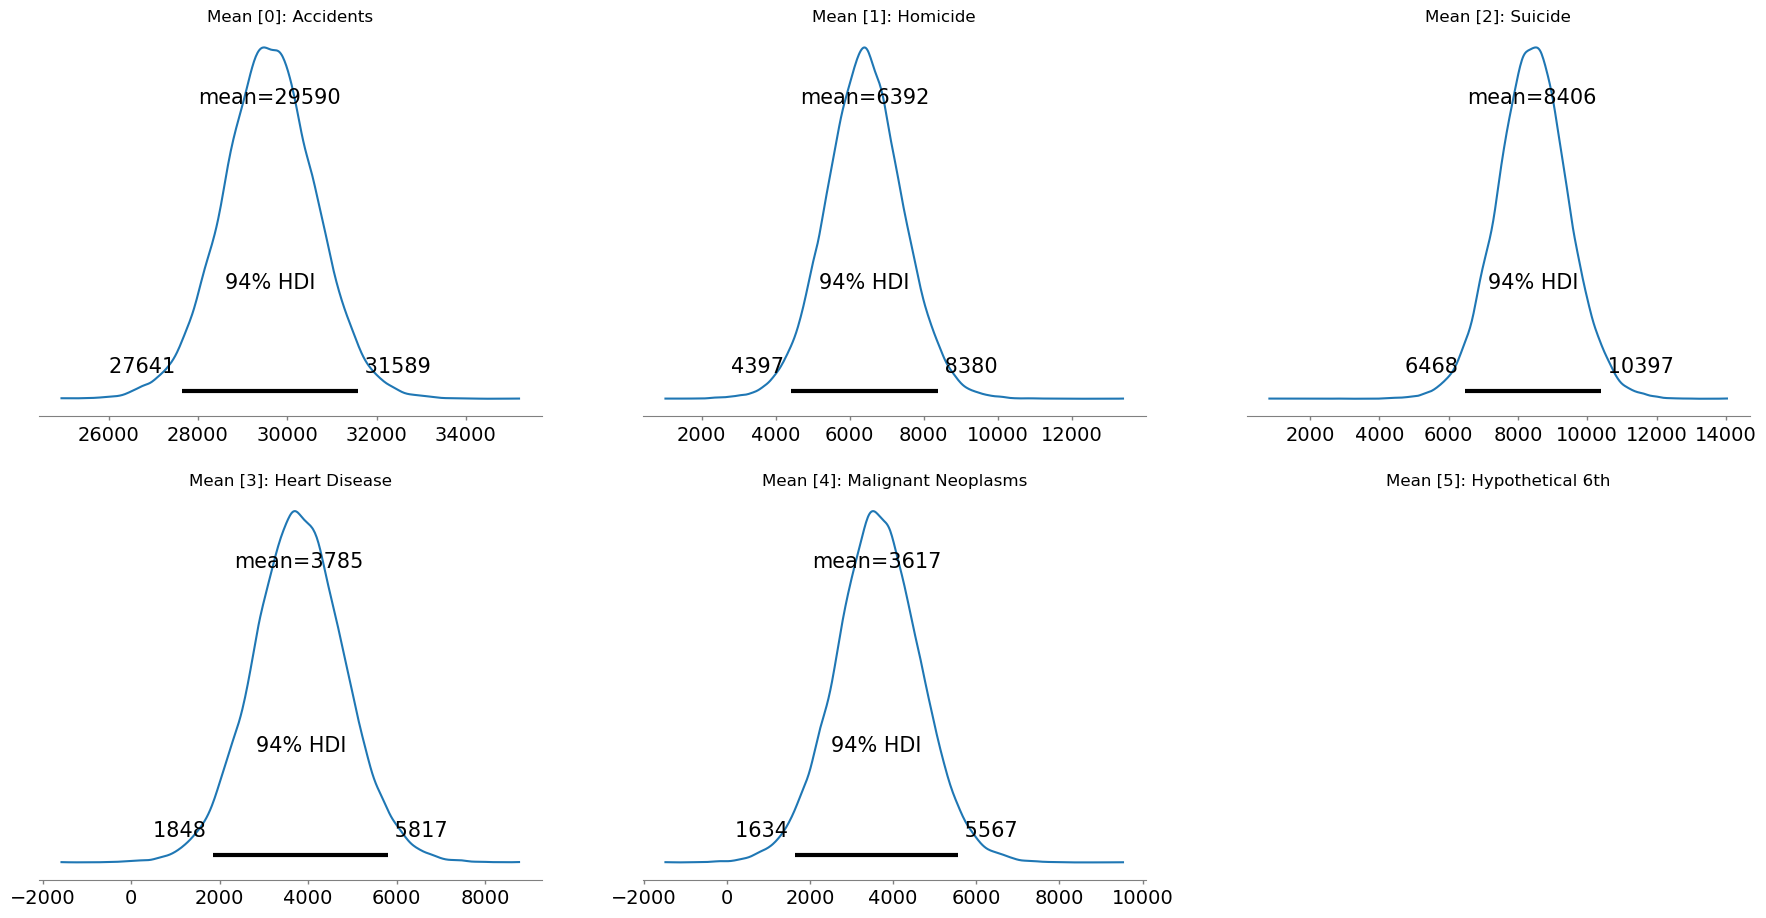

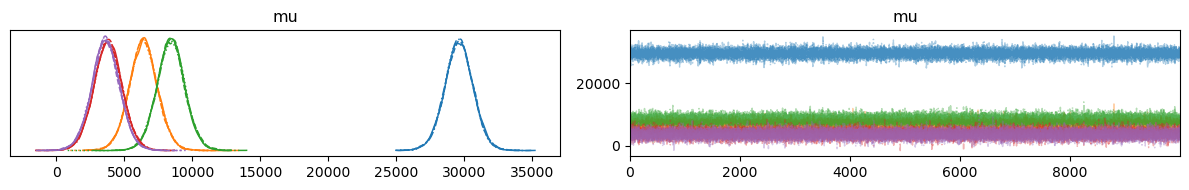

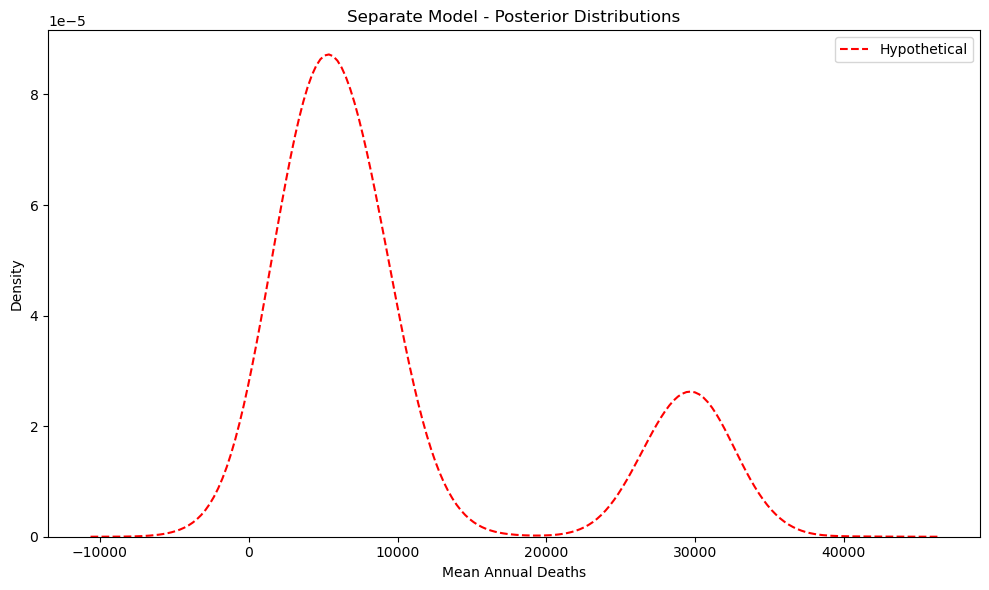


Separate Model Summary:
            mean        sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
mu[0]  29590.416  1051.907  27641.073  31588.766      4.862    3.439   
mu[1]   6392.463  1056.131   4396.999   8379.607      4.656    3.341   
mu[2]   8406.243  1039.529   6468.207  10396.504      5.081    3.596   
mu[3]   3785.054  1053.592   1847.519   5817.207      4.515    3.295   
mu[4]   3616.670  1041.929   1634.227   5566.682      4.735    3.481   

       ess_bulk  ess_tail  r_hat  
mu[0]   46942.0   27577.0    1.0  
mu[1]   51963.0   30508.0    1.0  
mu[2]   42188.0   30805.0    1.0  
mu[3]   54738.0   30575.0    1.0  
mu[4]   48736.0   30486.0    1.0  

Hypothetical Cause Statistics:
  Mean: 10347.87
  95% CI: (-184.69, 32440.43)


In [73]:
# Define the model with coordinates
coords = {'cause': list(cause_labels.values())}

# 1. Separate Model (using PyMC)
with pm.Model(coords=coords) as separate_model:
    #mu = pm.Normal('mu', mu=0, sigma=1e5, shape=K)
    #sigma = pm.HalfNormal('sigma', sigma=1e5)
    mu = pm.Normal('mu', mu=[prior_means[cause] for cause in data.keys()], sigma=1e5, shape=K)
    sigma = pm.HalfNormal('sigma', sigma=common_sigma)
    y_obs = pm.Normal('y_obs', mu=mu[:, None], sigma=sigma, observed=y)
    idata_separate = pm.sample(n_samples, tune=n_tune, return_inferencedata=True)

# Function to generate hypothetical cause
def generate_hypothetical(samples, n_samples=2000):
    mu_samples = samples.posterior['mu'].values.flatten()
    sigma_samples = samples.posterior['sigma'].values.flatten()
    
    # Ensure consistent sample size. Fixes pymc issue in sampling
    sample_size = min(len(mu_samples), len(sigma_samples), n_samples)
    mu_samples = mu_samples[:sample_size]
    sigma_samples = sigma_samples[:sample_size]
    
    return np.random.normal(mu_samples, sigma_samples)

# Generate hypothetical causes
hyp_separate = generate_hypothetical(idata_separate, n_samples=n_samples)

# Visualization function
def plot_posterior_means(samples):
    # Create the posterior plot
    ax = az.plot_posterior(samples, var_names=['mu'])
    # Flatten the axes array if it's 2D
    if isinstance(ax, np.ndarray):
        ax = ax.flatten()
    else:
        ax = [ax]
    
    # Add titles to each subplot
    for idx, subplot in enumerate(ax):
        title = cause_labels[idx]
        subplot.set_title(f"Mean [{idx}]: {title}")

    # Plot trace on bottom
    az.plot_trace(samples, var_names=['mu'])
    #az.set_title("Trace Plot of mu")

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

def plot_predictive_hypothetical(hyp):
    
    # Create a new figure for the posterior distribution, put all causes in one plot
    fig, ax = plt.subplots(figsize=(10, 6))
    #az.plot_posterior(samples, var_names=['mu'], ax=ax)
    sns.kdeplot(hyp, ax=ax, label='Hypothetical', linestyle='--', color='red')
    ax.set_title(f'Separate Model - Posterior Distributions')
    ax.set_xlabel('Mean Annual Deaths')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_posterior_means(idata_separate)
#plot_model_results(idata_separate, hyp_separate, data)

plot_predictive_hypothetical(hyp_separate)

# Print summary statistics
print("\nSeparate Model Summary:")
print(az.summary(idata_separate, var_names=['mu']))

# Print hypothetical cause statistics
print("\nHypothetical Cause Statistics:")
print(f"  Mean: {np.mean(hyp_separate):.2f}")
print(f"  95% CI: ({np.percentile(hyp_separate, 2.5):.2f}, {np.percentile(hyp_separate, 97.5):.2f})")

# Pooled Model - PYMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 4 seconds.


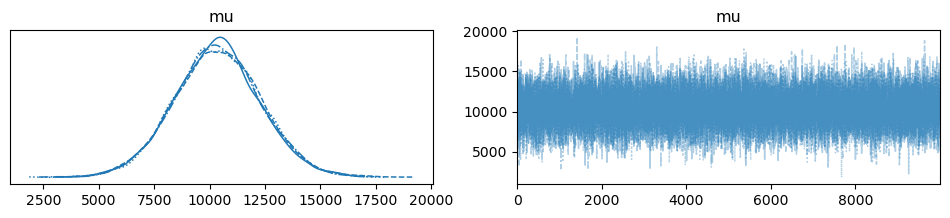

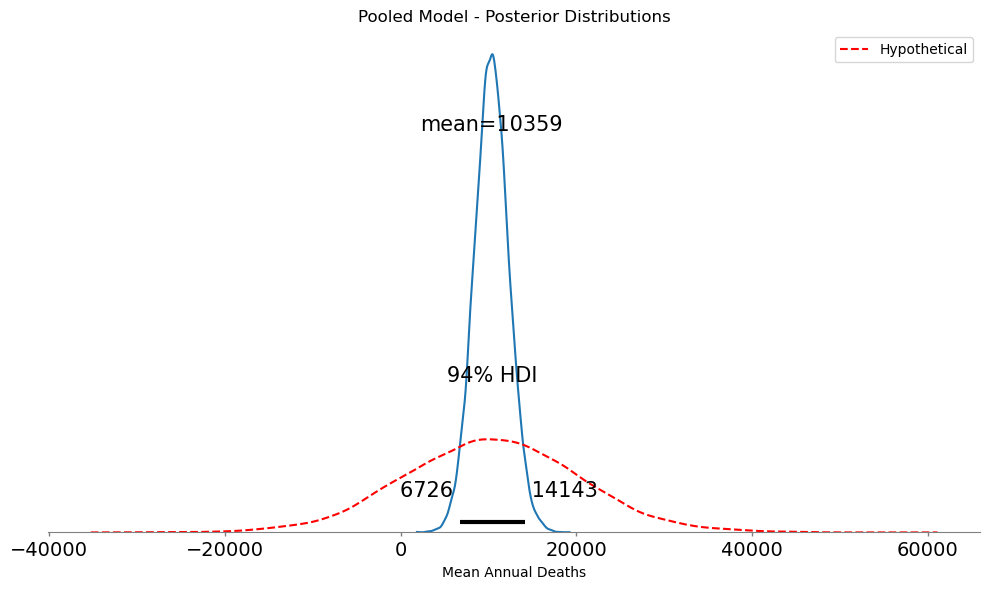


Pooled Model Summary:
         mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu  10358.508  1966.717  6725.631  14142.59     10.285    7.315   36686.0   

    ess_tail  r_hat  
mu   25487.0    1.0  

Hypothetical Cause Statistics:
  Mean: 10366.33
  95% CI: (-9167.55, 30243.82)


In [69]:
prior_means = {cause: np.mean(prior_data[cause]) for cause in prior_data.keys()}
prior_means_flattened = np.array(list(prior_means.values())).flatten()

# 2. Pooled Model (using PyMC)
with pm.Model() as pooled_model:
    mu = pm.Normal('mu', mu=np.mean(prior_means_flattened), sigma=1e5)
    sigma = pm.HalfNormal('sigma', sigma=common_sigma)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y.flatten())
    idata_pooled = pm.sample(n_samples, tune=n_tune, return_inferencedata=True)

# Function to generate hypothetical cause
def generate_hypothetical(samples, n_samples=2000):

    mu_samples = samples.posterior['mu'].values.flatten()
    sigma_samples = samples.posterior['sigma'].values.flatten()
    
    # Ensure consistent sample size
    sample_size = min(len(mu_samples), len(sigma_samples), n_samples)
    mu_samples = mu_samples[:sample_size]
    sigma_samples = sigma_samples[:sample_size]
    
    return np.random.normal(mu_samples, sigma_samples)

# Generate hypothetical causes
hyp_pooled = generate_hypothetical(idata_pooled, n_samples=n_samples)

# Visualization function
def plot_model_results(samples, hyp, data):
    # For PyMC models, create separate figures for trace plots
    az.plot_trace(samples, var_names=['mu'])
    plt.show()
    
    # Create a new figure for the posterior distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    az.plot_posterior(samples, var_names=['mu'], ax=ax)
    sns.kdeplot(hyp, ax=ax, label='Hypothetical', linestyle='--', color='red')
    ax.set_title(f'Pooled Model - Posterior Distributions')
    ax.set_xlabel('Mean Annual Deaths')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_model_results(idata_pooled, hyp_pooled, data)
print("\nPooled Model Summary:")
print(az.summary(idata_pooled, var_names=['mu']))
# Print hypothetical cause statistics
print("\nHypothetical Cause Statistics:")
print(f"  Mean: {np.mean(hyp_pooled):.2f}")
print(f"  95% CI: ({np.percentile(hyp_pooled, 2.5):.2f}, {np.percentile(hyp_pooled, 97.5):.2f})")

# Hierarchial Model

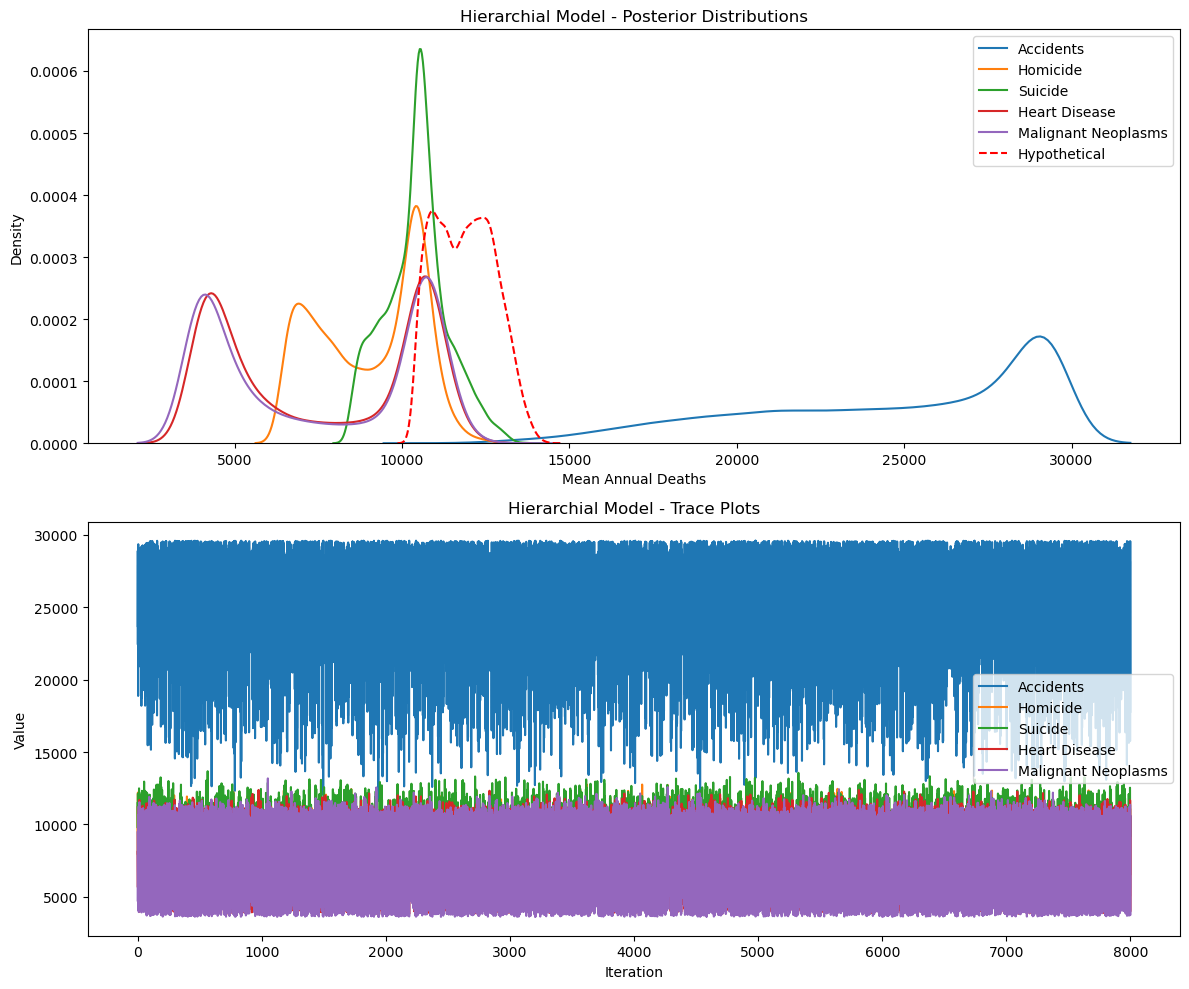

Hierarchial Model Summary:
Accidents:
  Mean: 24805.14
  95% CI: (15589.93, 29544.93)
Homicide:
  Mean: 9038.01
  95% CI: (6532.08, 11351.35)
Suicide:
  Mean: 10428.89
  95% CI: (8665.47, 12410.00)
Heart Disease:
  Mean: 7592.16
  95% CI: (3872.68, 11407.11)
Malignant Neoplasms:
  Mean: 7502.88
  95% CI: (3696.94, 11377.43)
Hypothetical Cause:
  Mean: 11873.42
  95% CI: (10487.23, 13518.92)


In [70]:
def gibbs_sampler_hierarchical(y, n_iter=15000, burn_in=5000):
    # use the means of the priors
    y2 = np.array(list(prior_data.values()))
    mu = y2.mean(axis=1)
    tau = np.full(y2.shape[0], 1 / common_variance)
    #tau = 1 / y2.var(axis=1)
    mu_0, tau_0 = 0, 1
    
    samples = {
        'mu': np.zeros((n_iter, K)),
        'tau': np.zeros((n_iter, K)),
        'mu_0': np.zeros(n_iter),
        'tau_0': np.zeros(n_iter)
    }
    
    for i in range(n_iter):
        # Sample mu
        for k in range(K):
            precision = N * tau[k] + tau_0
            mean = (tau[k] * np.sum(y[k]) + tau_0 * mu_0) / precision
            mu[k] = norm.rvs(mean, 1 / np.sqrt(precision))
        
        # Sample tau
        for k in range(K):
            alpha_post = 1 + N / 2
            beta_post = 1 + 0.5 * np.sum((y[k] - mu[k])**2)
            tau[k] = invgamma.rvs(alpha_post, scale=beta_post)
        
        # Sample mu_0
        precision = K * tau_0 + 1
        mean = tau_0 * np.sum(mu) / precision
        mu_0 = norm.rvs(mean, 1 / np.sqrt(precision))
        
        # Sample tau_0
        alpha_post = 1 + K / 2
        beta_post = 1 + 0.5 * np.sum((mu - mu_0)**2)
        tau_0 = invgamma.rvs(alpha_post, scale=beta_post)
        
        samples['mu'][i] = mu
        samples['tau'][i] = tau
        samples['mu_0'][i] = mu_0
        samples['tau_0'][i] = tau_0
    
    return {k: v[burn_in:] for k, v in samples.items()}

def generate_hypothetical_hierarchial(samples, n_samples=2000):

    mu_samples = samples['mu_0']
    tau_samples = samples['tau_0']
    
    sigma_samples = 1 / np.sqrt(tau_samples)
    
    # Ensure consistent sample size
    sample_size = min(len(mu_samples), len(sigma_samples), n_samples)
    mu_samples = mu_samples[:sample_size]
    sigma_samples = sigma_samples[:sample_size]
    
    return np.random.normal(mu_samples, sigma_samples)

def plot_model_results_hierarchial(samples, hyp, data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Posterior distributions
    for k, cause in enumerate(data.keys()):
        sns.kdeplot(samples['mu'][:, k], ax=ax1, label=cause)
    
    sns.kdeplot(hyp, ax=ax1, label='Hypothetical', linestyle='--', color='red')
    ax1.set_title(f'Hierarchial Model - Posterior Distributions')
    ax1.set_xlabel('Mean Annual Deaths')
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Trace plots
    for k, cause in enumerate(data.keys()):
        ax2.plot(samples['mu'][:, k], label=cause)
    
    ax2.set_title(f'Hierarchial Model - Trace Plots')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Value')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def print_summary_statistics_hierarchial(samples, data):
    print(f"Hierarchial Model Summary:")
    
    for k, cause in enumerate(data.keys()):
        print(f"{cause}:")
        print(f"  Mean: {np.mean(samples['mu'][:, k]):.2f}")
        print(f"  95% CI: ({np.percentile(samples['mu'][:, k], 2.5):.2f}, {np.percentile(samples['mu'][:, k], 97.5):.2f})")

# Run the models
samples_hierarchical = gibbs_sampler_hierarchical(y, n_iter=n_samples, burn_in=n_tune)

# Generate hypothetical causes
hyp_hierarchical = generate_hypothetical_hierarchial(samples_hierarchical, n_samples=n_samples)

# Plot the results
plot_model_results_hierarchial(samples_hierarchical, hyp_hierarchical, data)

# Print summary statistics
print_summary_statistics_hierarchial(samples_hierarchical, data)

# Print hypothetical cause statistics
print("Hypothetical Cause:")
print(f"  Mean: {np.mean(hyp_hierarchical):.2f}")
print(f"  95% CI: ({np.percentile(hyp_hierarchical, 2.5):.2f}, {np.percentile(hyp_hierarchical, 97.5):.2f})")